In [1]:
import pandas as pd
import numpy as np
import random
import nltk
import string
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics

In [2]:
df = pd.read_csv("../Dataset/dataset.csv")
df = df.drop(columns="data")
df.head()

,author,lyrics,style,title
0,Midian Lima,"Amanheceu,Nada pesquei,Parecia ser apenas mais...",eletrônica,Não Pare
1,MC Doni,"Não adianta tu se declarar,Romance, compromiss...",eletrônica,Te Amo Sem Compromisso (To Nem Aí)
2,Sebastián Yatra,"I remember when I met you,I didn't wanna fall,...",eletrônica,My Only One (No Hay Nadie Más) (part. Isabela ...
3,Billie Eilish,"Thought I found a way,Thought I found a way ou...",eletrônica,Lovely (feat. Khalid)
4,Ed Sheeran,"I found a love for me,Darling, just dive right...",eletrônica,Perfect


In [3]:
df["style"].unique()

array(['eletrônica', 'cumbia', 'zouk', 'pop', 'zamba', 'bolero',
       'post-rock', 'alternativo', 'brega', 'country', 'blues', 'dance',
       'disco', 'cuarteto', 'trova', 'soul', 'salsa', 'ska', 'reggaeton',
       'rockabilly', 'reggae', 'tango', 'regional', 'rock', 'samba',
       'tecnopop', 'sertanejo', 'power-pop', 'ranchera', 'mpb',
       'mariachi', 'industrial', 'infantil', 'indie', 'house',
       'instrumental', 'jazz', 'pagode', 'mambo', 'psicodelia',
       'merengue', 'hardcore', 'grunge', 'funk', 'folk', 'emocore',
       'fado'], dtype=object)

In [4]:
data = df.sample(frac=0.01, random_state=1)

In [3]:
def clean_string(sentence):
    if not isinstance(sentence, str):
        return ""
    for p in string.punctuation:
        sentence = sentence.replace(p, " ")
    sentence = sentence.replace("  ", " ")
    return sentence.lower()

In [6]:
tokens = []
for index, row in data.iterrows():
    tokens.append(nltk.word_tokenize(clean_string(row["lyrics"])) +  nltk.word_tokenize(row["title"]))
model = Word2Vec(tokens, min_count=1)

In [7]:
len(model.wv.vocab)

11652

In [8]:
X = model[model.wv.vocab]

/Users/paulocarneiro/MusicClassifier/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Tunning the number of cluster of the k-means algorithm

Following this [article](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [10]:
mms = MinMaxScaler()
mms.fit(X)
data_transformed = mms.transform(X)

Sum_of_squared_distances = []

K = range(1,int(len(model.wv.vocab) - 1), int(len(model.wv.vocab) * 0.1))
for k in K:
    print(f"----- Clustering for k = {k} -----")
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

----- Clustering for k = 1 -----
----- Clustering for k = 1166 -----
----- Clustering for k = 2331 -----
----- Clustering for k = 3496 -----
----- Clustering for k = 4661 -----
----- Clustering for k = 5826 -----
----- Clustering for k = 6991 -----
----- Clustering for k = 8156 -----
----- Clustering for k = 9321 -----
----- Clustering for k = 10486 -----


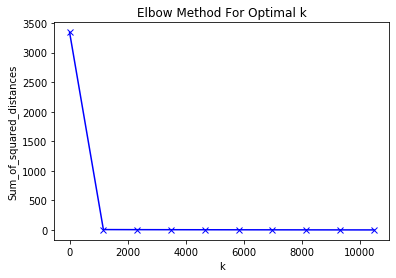

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Choose the k where sum_of_squared_distance tends to zero

In this case k = 1600

k was estimated using 11k words. Making a linear aproximation for 195k elements k will be:

k = 28300

## Clustering the dataset

In [4]:
NUM_CLUSTERS = 28300

In [5]:
tokens = []
for index, row in df.iterrows():
    tokens.append(nltk.word_tokenize(clean_string(row["lyrics"])) +  nltk.word_tokenize(row["title"]))
model = Word2Vec(tokens, min_count=1)

X = model[model.wv.vocab]

/Users/paulocarneiro/MusicClassifier/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [6]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

KeyboardInterrupt: 

## Saving the clusters in a json file

In [ ]:
words = list(model.wv.vocab)
new_array = np.asarray(labels)
clusters = {}
clusters["clusters"] = {}
clusters["replace"] = {}
for i in range(NUM_CLUSTERS):
    ids_ = np.where(new_array == i)
    print(f"=========== Cluster {i} ========== ")
    for ids in ids_[0]:
        if i not in clusters["replace"]:
            clusters["replace"][i] = words[ids]
        print(words[ids])
        clusters["clusters"][words[ids]] = i
        
import json
with open("clusters.json", "w") as f:
    json.dump(clusters,f)